# Citibike Ridership Time Series Analysis

Predicting Citibike ridership in 2022 for my Flatiron School Capstone project

Author: Jeff Marvel

## Overview

Citibike, NYC's bikeshare program owned and operated by Lyft, has become massively popular. With over 1,000 stations in almost every borough (sorry Staton Island) plus downtown Jersey City, Citibike has become an indispensable part of NYC's transportation infrastructure. Thousands of people rely on Citibike for their daily commuting, moving around their neighborhood, or helping bridge any gaps left by traditional city transportation infrastructure (subway, buses, etc). In additon, studies have linked bikeshare programs to lower pollution and safer streets.

While the city-wide lockdown in March of 2020 for the COVID-19 pandemic resulted in a sharp decrease in Citibike usage, ridership has more than bounced back in 2021 and is on pace for a record-breaking year. With two months still to go, 2021 ridership has already topped 24 million rides, breaking the previous record of 21 million from 2019. Given it's growth in popularity, which shows no signs of slowing, it's important to be able to accurately forecast ridership for the system overall, and also for each neighborhood in NYC.

See the README on this project's Github for sources to the above (https://github.com/marvelje/citibike_ridership_project/blob/main/README.md)

## Business Problem

Lyft, the parent company that owns and operates Citibike, is looking for an accurate forecast of 2022 expected ridership. In a recent blog post covering the record ridership in 2021, they have said that the system's increase in popularity has caused strains on the system and a frustrating user experience (link below). In this context, it's important to build an accurate projection of ridership to ensure Citibike can meet this demand. This model will help Lyft with general business planning, including:
- Financial forecasting
- Hiring appropriate staff (station managers, mechanics, etc)
- Having a sufficient supply of Citibikes

In addition, Lyft would like a better understanding of neighborhood-level forecasts. This can help Lyft better plan which neighborhoods could benefit from additional stations and otherwise improve its resource allocation.

Link for Citibike's blog: https://ride.citibikenyc.com/blog/ridershiprecords

## Data Understanding

- The source data from Citibike (https://ride.citibikenyc.com/system-data) includes ride level details for every ride taken since the program's launch in 2013. The data comes in monthly CSV files that are available for download.
- Overall, this represents 130mm+ individual rides over 8 years.
- The standard fields include origin station, destination station, station coordinates, start time, stop time, user type (member or guest), bike ID, and user gender.

### Initial Data Processing

- Before even publishing the data, Citibike performs a few basic data cleaning steps:
    - Removes rides taken by staff to move bikes around or test the system
    - Rides to / from test stations (primarily relevant in 2013)
    - Rides under 60 seconds. These potentially represent users re-docking a broken bike or users ensuring that a particular bike is securely docked
- In order to trim the data to a size that can be run on a local machine, I processed each monthly CSV file they are read in (full details in 'citibike_data_import.ipynb').
    - Data was consolidated by station and by day (e.g., each of the 1,00+ stations has daily ridership counts)
    - Start Time was used to classify by day (i.e., a ride that starts at 11:59pm but ends the next day is classified on the day it started)
    - Many fields were dropped. Given that I'm eventually forecasting ridership by neighborhood, I kept only Start Time, Start Station ID, Start Station Latitude, Start Station Longitude, and Ride Count
- Prior to performing EDA, neighborhood and borough were appended to the dataset by pairing lat / long with a geo_json file on neighborhoods published by NYC open data portal
    - There were a few stations with coordinates in Montreal (and even French sounding names). These were removed.
    - Station with blank coordinate data were also removed. Collectively, these stations represented only dozens of rides out of 100mm+
    - See 'citibike_data_import.ipynb' for full details
- These resulting CSVs were concatenated resulting in a final daily time series that's ~2mm rows long

In [71]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape

# Set style
plt.style.use('seaborn')

In [2]:
# Time series imports

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

In [3]:
# EDA util file imports

from util.eda_util import process_neighborhood, dickey_fuller, adjust_length

In [4]:
# Read in the data
# The station ID is mixed column type so need to specify low_memory=False

df_citibike = pd.read_csv('./clean_data/clean_ridershare_data.csv', low_memory=False)

In [5]:
# Ensure data has loaded correctly

df_citibike.head()

,starttime,station_id,lat,long,ride_count,year,neighborhood,borough
0,2013-06-01,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
1,2013-06-01,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2,2013-06-01,82,40.711174,-74.000165,6,2013,Chinatown,Manhattan
3,2013-06-01,83,40.683826,-73.976323,32,2013,Fort Greene,Brooklyn
4,2013-06-01,116,40.741776,-74.001497,53,2013,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [6]:
df_citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2144526 entries, 0 to 2144525
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   starttime     object 
 1   station_id    object 
 2   lat           float64
 3   long          float64
 4   ride_count    int64  
 5   year          int64  
 6   neighborhood  object 
 7   borough       object 
dtypes: float64(2), int64(2), object(4)
memory usage: 130.9+ MB


In [7]:
# # Convert starttime to a datetime object and set as index
df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])
df_citibike = df_citibike.set_index('starttime')

# Print to ensure it's worked correctly
df_citibike.head(2)

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2013-06-01,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
2013-06-01,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan


## Data Preparation

To ensure a final, clean dataset for modeling, I've taken the following additional data processing steps:

- After filling in missing info (process detailed below), I removed neighborhoods with missing coordinate information and a few stations that snuck in from Montreal (still confused by this one)
- Create a new dataframe that is only comprised of neighborhoods that had rides 2017 or later. This is to ensure that the models for those neighborhoods have enough data to train on.
    - This reduces the final neighborhood count by half (from 82 to 41). However, this still preserves 96% of the total rides take since program launch.
- Backfill the 9 dates with blank ridership info. This was one week in January 2016, 2/9/2017, and a week in March 2017. The blank data appears to be an upstream Citibike issue. Given the small number of missing dates, backfilling appears to be the best option.

In [8]:
# Check for blank neighborhoods / boroughs

df_citibike.isna().sum()

station_id        0
lat               0
long              0
ride_count        0
year              0
neighborhood    284
borough         284
dtype: int64

In [9]:
# Examine these null neighborhoods

null_neighborhood = df_citibike[df_citibike['neighborhood'].isna()]

display(null_neighborhood.head())

print(f"Number of rides: {null_neighborhood['ride_count'].sum()} ")

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2016-12-09,3240,0.00000,0.000000,1,2016,NaN,NaN
2016-12-23,3240,0.00000,0.000000,1,2016,NaN,NaN
2016-12-29,3240,0.00000,0.000000,1,2016,NaN,NaN
2017-01-02,3240,40.75903,-73.993859,2,2017,NaN,NaN
2017-01-03,3240,40.75903,-73.993859,2,2017,NaN,NaN


Number of rides: 2060 


There are only 2060 rides from stations without neighborhood / borough tags. That's no many relative to the size of the dataset, but I will investigate below if there are obvious ways to fill these gaps.

In [10]:
# Consolidate by unique station for easier plotting

df_unique = df_citibike.drop_duplicates(subset='station_id')

df_stations = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

df_stations.info()

# There may be some "duplicate stations" given that the station IDs may not be consistently named through time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3422 entries, 0 to 3421
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  3422 non-null   object 
 1   lat         3422 non-null   float64
 2   long        3422 non-null   float64
dtypes: float64(2), object(1)
memory usage: 80.3+ KB


In [11]:
# Simplify down to only lat and long

df_lat_long = df_stations[['lat', 'long']]

# Convert to geopandas object

gdf_citibike = gpd.GeoDataFrame(df_lat_long, geometry=gpd.points_from_xy(df_lat_long.long, df_lat_long.lat))

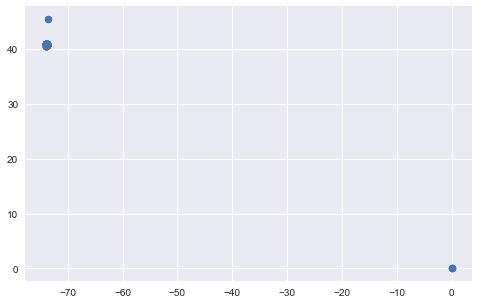

In [12]:
# Plot the stations
# There appears to be two groups of outliers: stations without coordinates and stations that look to be outside NYC
# Looking up the higher coordinates, appears there are some stations in Montreal. These will obviously be dropped

gdf_citibike.plot();

There are a few stations with a lat / long of 0 and another clump of points that appear to be well north of NYC.

In [13]:
# Find list of all the outlier station IDs

outlier_coord = df_stations[(df_stations['lat'] >= 42) | (df_stations['lat'] == 0)]

outlier_stations = list(outlier_coord['station_id'])

outlier_stations

['3240', '3446', '3248', '3488', '3633', '3215', '3480', '3650']

In [14]:
# Lookup these null values in the main dataframe
# There are only 4,000 rides that fall under these stations. This is probably the majority of the neighborhood
# nulls that we see above

outlier_check = df_citibike[df_citibike['station_id'].isin(outlier_stations)]

outlier_check['ride_count'].sum()

3677

In [15]:
outlier_check.head()

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2016-12-09,3240,0.00000,0.000000,1,2016,NaN,NaN
2016-12-23,3240,0.00000,0.000000,1,2016,NaN,NaN
2016-12-29,3240,0.00000,0.000000,1,2016,NaN,NaN
2017-01-02,3240,40.75903,-73.993859,2,2017,NaN,NaN
2017-01-03,3240,40.75903,-73.993859,2,2017,NaN,NaN


In [16]:
# I notice that a few 3240 stations have blank lat / long, but the rest have coordinate / neighborhood info
# I will fill these blank values with the coordinates that appear in the rest of the dataset for these stations.

display(outlier_check[(outlier_check['station_id'] == '3240') & (outlier_check['lat'] == 0)])
display(outlier_check[outlier_check['station_id'] == '3240'].iloc[150:152,:])

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2016-12-09,3240,0.0,0.0,1,2016,NaN,NaN
2016-12-23,3240,0.0,0.0,1,2016,NaN,NaN
2016-12-29,3240,0.0,0.0,1,2016,NaN,NaN


,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2021-05-06,3240,40.649037,-73.97673,9,2021,Windsor Terrace,Brooklyn
2021-05-07,3240,40.649037,-73.97673,12,2021,Windsor Terrace,Brooklyn


In [18]:
# Fill in missing values for the 3240 station

df_citibike[(df_citibike['station_id'] == '3240') & (df_citibike['lat'] == 0)] = ['3240', 40.649037, -73.976730, 
                                                                                1, 2016, 'Windsor Terrace','Brooklyn']

In [19]:
# Rerun cells above to check new list of outliers
# Find unique set of stations

df_unique = df_citibike.drop_duplicates(subset='station_id')

df_stations = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

In [20]:
# Find list of all the outlier station IDs
# Only 206 total rides (out of 10s of millions) are associated with stations without an ID

outlier_coord = df_stations[(df_stations['lat'] >= 42) | (df_stations['lat'] == 0)]

outlier_stations = list(outlier_coord['station_id'])

outlier_check = df_citibike[df_citibike['station_id'].isin(outlier_stations)]

outlier_check['ride_count'].sum()

206

In [21]:
# One final check: these stations with missing lat / long do not have other details we can use to fill them in
# Stations will be dropped from the dataframe

df_citibike[df_citibike['station_id'].isin(list(df_stations[df_stations['lat'] == 0]['station_id']))]

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2017-01-30,3446,0.0,0.0,2,2017,NaN,NaN
2017-06-27,3248,0.0,0.0,2,2017,NaN,NaN
2017-09-14,3633,0.0,0.0,1,2017,NaN,NaN
2017-10-01,3215,0.0,0.0,7,2017,NaN,NaN
2017-10-01,3480,0.0,0.0,17,2017,NaN,NaN
2017-10-02,3215,0.0,0.0,1,2017,NaN,NaN
2017-10-02,3480,0.0,0.0,13,2017,NaN,NaN


In [22]:
# Final dataset will remove remaining stations with 0 coordinates and those with a latitude above 42

df_citibike = df_citibike[(df_citibike['lat'] != 0) & (df_citibike['lat'] < 42)]

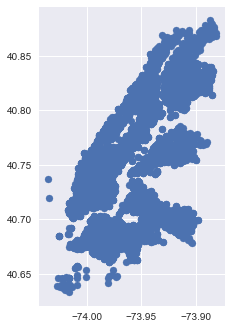

In [23]:
# Redo the steps above for the final stations

# Find unique set of stations

df_unique = df_citibike.drop_duplicates(subset='station_id')

df_stations = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

# Simplify down to only lat and long

df_lat_long = df_stations[['lat', 'long']]

# Convert to geopandas object

gdf_citibike = gpd.GeoDataFrame(df_lat_long, geometry=gpd.points_from_xy(df_lat_long.long, df_lat_long.lat))

gdf_citibike.plot();

After filling in missing station details and removing remaining stations with missing coordinate information and the handful from Montreal, the final coordinate plot looks like a very reasonable approximation of NYC.

In [24]:
# Drop any remaining null neighborhoods

df_citibike.dropna(subset=['neighborhood'], inplace=True)

In [25]:
# Check for missing dates

daily_ridership_overall = df_citibike[['ride_count']].resample('1D').sum()

daily_ridership_overall[daily_ridership_overall['ride_count'] == 0]

# There are a handful of dates that do not have ridership info. They are grouped together, suggesting
# a data entry type error. I will back fill these values with the previous relevant date.

,ride_count
starttime,
2016-01-23,0
2016-01-24,0
2016-01-25,0
2016-01-26,0
2017-02-09,0
2017-03-14,0
2017-03-15,0
2017-03-16,0
2021-02-02,0


When the data is resampled by day, there are a few dates with 0 rides. They are generally clumped together (i.e., there's a chucnk from the same week in January 2016). Given the small number of dates affected, I will backfill these with the previous non-zero value

Next I will filter the neighborhood list for those that had stations prior to 2017. This will ensure that the model has sufficient data to train on, depending on how I want to deal with the COVID downturn.

2017 was chosen, because as I show below, this still preserves almost the entirety of the rides taken in the system (96% of all rides preserved in chosen neighborhoods).

In [26]:
# Look for stations that didn't exist prior to 2017

df_pre_2017 = df_citibike[df_citibike.index < '2017-01-01']

pre_2017_neighborhoods = list(df_pre_2017['neighborhood'].unique())

print(f"Total number of neighborhoods: {len(df_citibike['neighborhood'].unique())}")
print(f"Number of neighborhoods with stations prior to 2017: {len(pre_2017_neighborhoods)}")

Total number of neighborhoods: 82
Number of neighborhoods with stations prior to 2017: 41


In [27]:
# Filter dataframe for only the relevant neighborhoods
# By reducing the neighborhoods by half, we still capture 96% of the original ride count in the dataset

df_neighborhood_f = df_citibike[df_citibike['neighborhood'].isin(pre_2017_neighborhoods)]

df_neighborhood_f['ride_count'].sum() / df_citibike['ride_count'].sum()

0.9563727373921386

In [28]:
# Visually examine neighborhoods that have been dropped
# Neighborhoods from recent expansion include Astoria, parts of the Bronx, and East Brooklyn

neighborhoods_dropped = [n for n in list(df_citibike['neighborhood'].unique()) if n not in pre_2017_neighborhoods]

neighborhoods_dropped

['East Harlem North',
 'Central Harlem South',
 'Central Harlem North-Polo Grounds',
 'Astoria',
 'Old Astoria',
 'Steinway',
 'park-cemetery-etc-Queens',
 'Crown Heights South',
 'Prospect Lefferts Gardens-Wingate',
 'Manhattanville',
 'Bushwick North',
 'Ocean Hill',
 'Ridgewood',
 'Washington Heights South',
 'Mott Haven-Port Morris',
 'Melrose South-Mott Haven North',
 'Hamilton Heights',
 'West Concourse',
 'Washington Heights North',
 'East Concourse-Concourse Village',
 'Highbridge',
 'Claremont-Bathgate',
 'Longwood',
 'Hunts Point',
 'Morrisania-Melrose',
 'Crotona Park East',
 'park-cemetery-etc-Bronx',
 'Mount Hope',
 'Woodside',
 'Sunset Park East',
 'Kensington-Ocean Parkway',
 'Flatbush',
 'Bay Ridge',
 'Borough Park',
 'Marble Hill-Inwood',
 'University Heights-Morris Heights',
 'Fordham South',
 'Bedford Park-Fordham North',
 'Kingsbridge Heights',
 'Van Cortlandt Village',
 'Norwood']

In [29]:
# Create geopandas object on the unique neighborhoods of the full dataset

df_unique1 = df_citibike.drop_duplicates(subset='station_id')

df_stations1 = df_unique1[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

df_lat_long1 = df_stations1[['lat', 'long']]

# Convert to geopandas object

gdf_citibike1 = gpd.GeoDataFrame(df_lat_long1, geometry=gpd.points_from_xy(df_lat_long1.long, df_lat_long1.lat))

In [30]:
# Creat geopandas object only on the filtered neighborhoods

df_unique2 = df_neighborhood_f.drop_duplicates(subset='station_id')

df_stations2 = df_unique2[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

df_lat_long2 = df_stations2[['lat', 'long']]

# Convert to geopandas object

gdf_citibike2 = gpd.GeoDataFrame(df_lat_long2, geometry=gpd.points_from_xy(df_lat_long2.long, df_lat_long2.lat))

In [31]:
# Read in NYC shape file. I will overlay the citibike stations on this

nyc_zip = gpd.read_file('./nyc_geo_data/2010 Neighborhood Tabulation Areas (NTAs)/geo_export_a805ec3d-23e6-435e-b964-dd8c3b1c25de.shp')

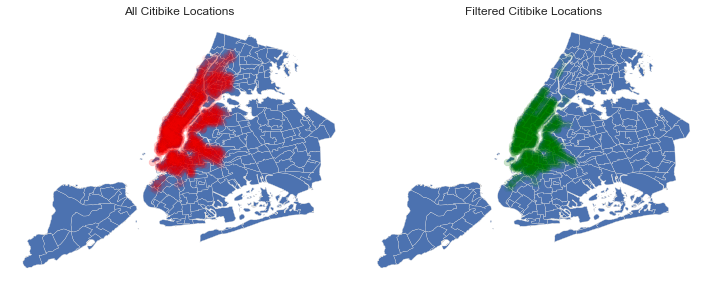

In [32]:
# Plot the citibike stations

fig, ax = plt.subplots(ncols=2, figsize=(10,10))

base = nyc_zip.plot(ax = ax[0], edgecolor='gainsboro')
gdf_citibike1.plot(ax=ax[0], color='red', alpha=0.05)
ax[0].set_title('All Citibike Locations')
ax[0].axis('Off');

base = nyc_zip.plot(ax = ax[1], edgecolor='gainsboro')
gdf_citibike2.plot(ax=ax[1], color='green', alpha=0.05)
ax[1].set_title('Filtered Citibike Locations')
ax[1].axis('Off')

plt.tight_layout();

# Comments: by filtering for only stations that existing prior to 2017, we lose a lot of the Bronx,
# Astoria, and parts of upper Manhattan.

Comments: by filtering for only stations that existing prior to 2017, we lose a lot of the Bronx, Astoria, and parts of upper Manhattan. These are neighborhoods that have been added within the past couple years so it makes sense to exclude for this analysis.

Next steps will be to continue to train this model and expand the neighborhood list as more data becomes available.

## Data exploration

- For full dataset:
    - Outside of 2020 (driven by COVID-19), ridership has steadily increased, up to 24mm so far in 2021
    - The vast majority of rides were started in Manhattan, followed by Brooklyn, Queens, and the Bronx. Citibike only recently expanded into the latter two boroughs, and they have experienced rapid growth since launch.
    - The daily plot of rides highlights two seasonal components: weekly and yearly. 
        - Ridership increases as the weather warms up (peaking in July and August)
        - More people take rides during the week as well (as part of their commute)
    - A dickey-fuller test shows that we cannot reject the null that the data is not stationary. Simply log transforming the data makes it roughly stationary although there is still an upward trend and seasonality present.
    - Decomposing the time series shows the trends that were apparent from the overall plot: yearly / weekly seasonality and an upward trend over time.

### Full Dataset Exploration

Number of rides per year: Citibike has experienced over 3x growth since 2014. 2021 has broken the record with 24mm rides and almost two months to go.

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_1523/2773025155.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=years, fontsize=14)


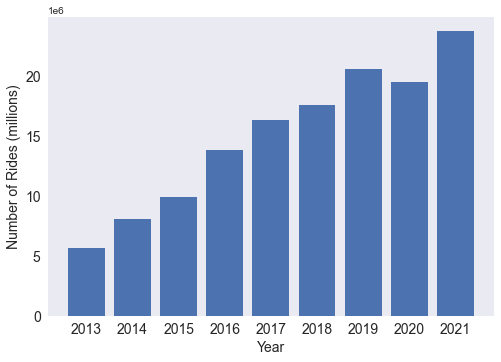

In [88]:
# Number of rides per year

fig, ax = plt.subplots();

# Resample for yearly ride count and sum
df_year = df_citibike[['ride_count']].resample('1Y').sum()

df_year['ride_count'] = df_year['ride_count'].astype('float64')

start = 2013
years = [start + i for i in range(9)]

ax.bar(x=years, height=df_year['ride_count'])
ax.set_ylabel('Number of Rides (millions)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
ax.set_xticklabels(labels=years, fontsize=14)
plt.xticks(years)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.grid(False);

In [37]:
# Create grouped datasets by borough

borough_df = df_citibike.groupby(['year','borough']).agg({'ride_count': 'sum'}).reset_index()

# Create individual lists of ridership by borough
manhattan = list(borough_df[borough_df['borough'] == 'Manhattan']['ride_count'])
brooklyn = list(borough_df[borough_df['borough'] == 'Brooklyn']['ride_count'])
queens = list(borough_df[borough_df['borough'] == 'Queens']['ride_count'])
bronx = list(borough_df[borough_df['borough'] == 'Bronx']['ride_count'])

queens = adjust_length(queens)
bronx = adjust_length(bronx)

Vast majority of rides continue to be ni Manhattan. Brooklyn has grown, followed by a large increase in Queens as well. The Bronx also got its first Citibike station in 2020, but has seen significant growth so far in 2021.

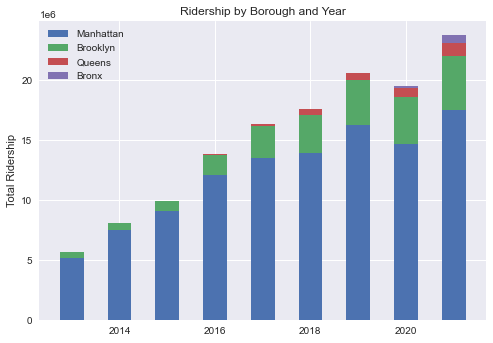

In [38]:
# Plot stacked bar with ridership by borough

import matplotlib.pyplot as plt

labels = years
width = 0.5      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, manhattan, width, label='Manhattan')
ax.bar(labels, brooklyn, width, label='Brooklyn', bottom=manhattan)
ax.bar(labels, queens, width, label='Queens', bottom=[a + b for a, b in zip(manhattan, brooklyn)])
ax.bar(labels, bronx, width, label='Bronx', bottom=[a + b + c for a, b, c in zip(manhattan, brooklyn, queens)])

ax.set_ylabel('Total Ridership')
ax.set_title('Ridership by Borough and Year')
ax.legend()
ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

plt.show();

# Vast majority of rides continue to be ni Manhattan. Brooklyn has grown, followed by a large increase in Quees
# as well. The Bronx also got its first Citibike station in 2020, but has seen significant growth so far in 2021.

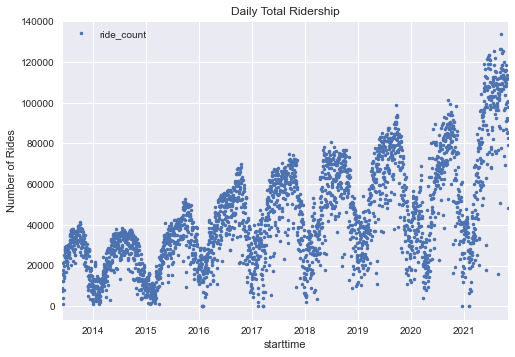

In [39]:
# Show a line plot of daily ridership by day

fig, ax = plt.subplots()
ax.set_title('Daily Total Ridership')
ax.set_ylabel('Number of Rides')
ax.set_xlabel('Date')

daily_ridership_overall = df_citibike[['ride_count']].resample('1D').sum()

daily_ridership_overall.plot(ax=ax, style = '.');

# This exhibits a few classic characteristics of non-stationary data:
# Time dependent mean: the number of rides is increasing over time
# There is seasoanlity: The ridership numbers clearly peak during the summer months
# Non-stationary variance: the peaks / troughs of the seasonality increase over time
# The handful of dates with 0 are apparent here as well
# There are also a few outlier points that I will need to consider how to treat. It's possible 
# There was some external event (power outage) that could've the decrease on those days

This exhibits a few classic characteristics of non-stationary data:
- Time dependent mean: the number of rides is increasing over time
- There is seasoanlity: The ridership numbers clearly peak during the summer months
- Non-stationary variance: the peaks / troughs of the seasonality increase over time
- The handful of dates with 0 are apparent here as well
- There are also a few outlier points that I will need to consider how to treat. It's possible 
- There was some external event (power outage) that could've the decrease on those days

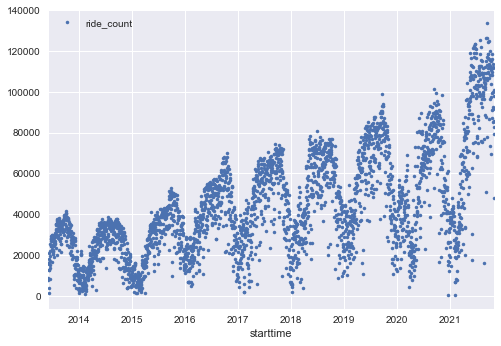

In [40]:
# Backfill the few dates with missing ridership information

daily_ridership_overall['ride_count'] = daily_ridership_overall['ride_count'].replace(to_replace=0, method='bfill')

# Replot the data to ensure it's still sensible
daily_ridership_overall.plot(style = '.');

# Looks about the same as previous, but no dates have 0 riders

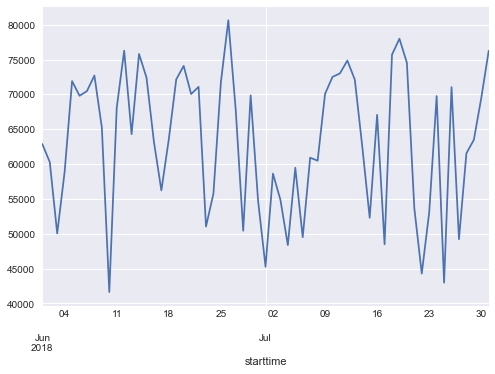

In [41]:
# Plotting only two months of data makes the weekly trend somewhat more apparent
# There is a sharp drop in ridership on the weekends

daily_ridership_overall[(daily_ridership_overall.index > '5/31/2018') & 
                        (daily_ridership_overall.index < '8/1/2018')]['ride_count'].plot();

In [42]:
# This data does not appear stationary, but we can run a Dickey Fuller test just to confirm

print('Original time series:')
stationary1, p1 = dickey_fuller(daily_ridership_overall['ride_count'], plot_log=False, print_output=True)
print('')
print('Log transformed:')
stationary2, p2 = dickey_fuller(daily_ridership_overall['ride_count'], plot_log=True, print_output=True)

# Simply log transforming the dataset appears to make the data almost stationary

Original time series:
Data is not stationary. P-value of 0.2462

Log transformed:
Data is not stationary. P-value of 0.0503


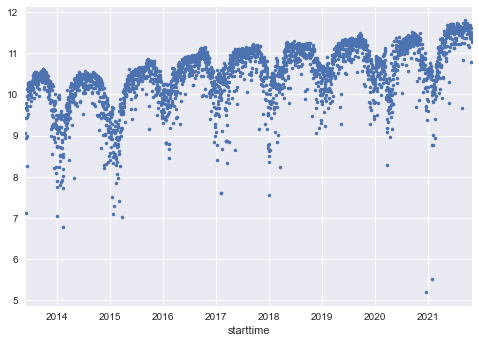

In [43]:
# Plot the log transformed data

daily_ridership_overall['ride_count_log'] = daily_ridership_overall['ride_count'].apply(lambda x: np.log(x))

daily_ridership_overall['ride_count_log'].plot(style = '.');

# Not bad, although there's still the seasonal trend that would be good to remove

Log transformed data is almost stationary, but we'll have to deal with the seasonality still. Differencing could also help.

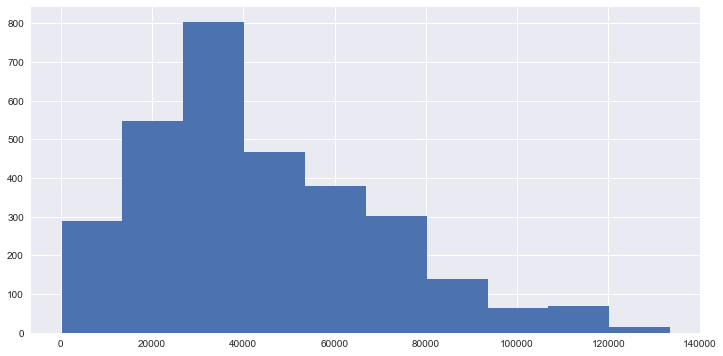

In [44]:
# Plot a histogram of the ridership data
daily_ridership_overall['ride_count'].hist(figsize = (12,6))
plt.show();

There is a strong tail on the data, further evidence for log transforming

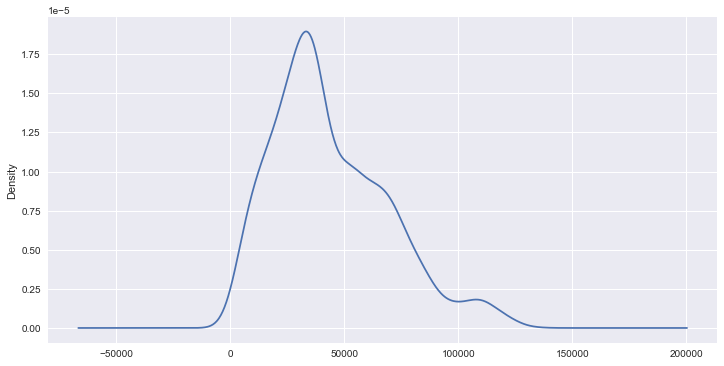

In [45]:
# Plot a density plot for temperature dataset
daily_ridership_overall['ride_count'].plot(kind='kde', figsize = (12,6))
plt.show();

You can see the tail towards the lower ride count here as well. This chart is a bit confusing as it suggests there are some values below 0. Confirmed that there are no negative values in the dataset.

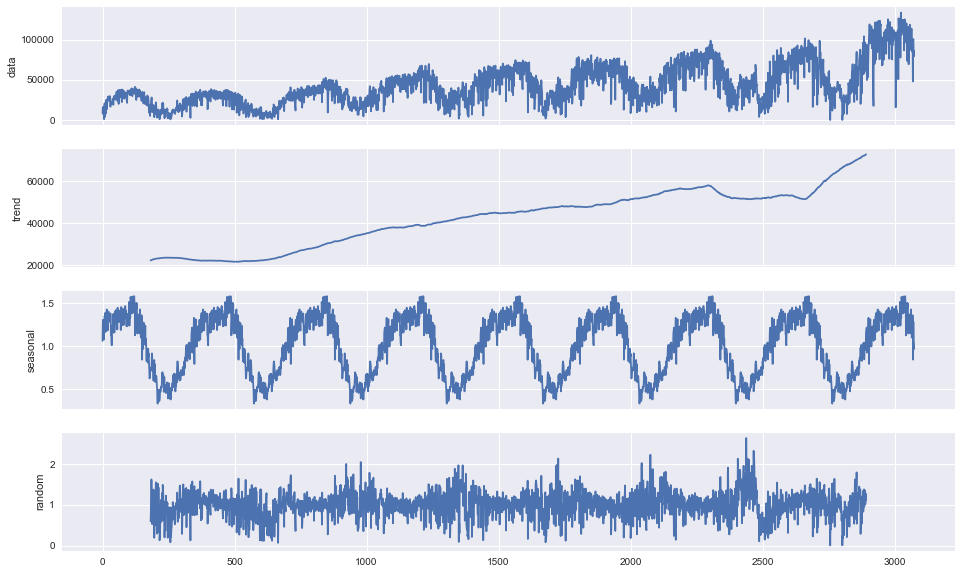

In [46]:
# Plot the decomposition of the overall time series

ts = daily_ridership_overall['ride_count']

decomposed_ts = decompose(daily_ridership_overall['ride_count'].values, 'multiplicative', m=365)

decomposed_plot(decomposed_ts, figure_kwargs={'figsize': (16, 10)})
plt.show()

We clearing see the yearly seasonality here and the upward trend in ridership

### Neighborhood Exploration
- The vast majority of rides have happened in Manhattan, particularly midtown and lower manhattan.
- Further down the list are neighborhoods that received stations as part of an expansion like upper Manhattan and Brooklyn
- Every neighborhood has at least 10 stations (Williamsburg is at the bottom). Manhattan locations top the list, but surprisingly, a few neighborhoods in Brooklyn are close behind. This might reflect:
    - Recent station expansion where ridership hasn't caught up
    - These neighborhoods are less inclined towards heavy ridership (not commuting towns, for example)
- Many stations are technically stationary without any transformation according to the Dickey-Fuller test, however, I may want to still log transform each neighborhood to make them even more stationary.
- Plotting line charts for each of the neighborhoods shows that most exhibit the same trend as the overall data (as expected).
    - However, several adjacent neighborhoods in Brooklyn have a precipitous drop in ridership during summer 2021. This appears to be an upstream data issue. Since I don't believe that I would include it in my training set, I'm inclined to leave these neighborhoods in for now.

In [47]:
pre_2017_neighborhoods

['Clinton',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Chinatown',
 'Fort Greene',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Bedford',
 'West Village',
 'Midtown-Midtown South',
 'Brooklyn Heights-Cobble Hill',
 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill',
 'Lower East Side',
 'Murray Hill-Kips Bay',
 'Turtle Bay-East Midtown',
 'Battery Park City-Lower Manhattan',
 'East Village',
 'Clinton Hill',
 'Sunset Park West',
 'North Side-South Side',
 'Gramercy',
 'park-cemetery-etc-Brooklyn',
 'Carroll Gardens-Columbia Street-Red Hook',
 'Lincoln Square',
 'Park Slope-Gowanus',
 'Stuyvesant Town-Cooper Village',
 'park-cemetery-etc-Manhattan',
 'Lenox Hill-Roosevelt Island',
 'Upper East Side-Carnegie Hill',
 'Hunters Point-Sunnyside-West Maspeth',
 'Queensbridge-Ravenswood-Long Island City',
 'Greenpoint',
 'East Williamsburg',
 'Williamsburg',
 'Bushwick South',
 'Stuyvesant Heights',
 'Crown Heights North',
 'Upper West Side',
 'Yorkville',
 'East Harlem South',
 'Morning

In [48]:
# Create a list of all the neighborhood dataframes

df_dict = {}

for neighborhood in pre_2017_neighborhoods:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict[neighborhood] = df

In [49]:
# Aggregate the neighborhoods by total number of rides and sort

df_neighborhood_sum = pd.DataFrame(index=pre_2017_neighborhoods, columns=['total_rides'])
i = 0
for df in df_dict.values():
    
    df_neighborhood_sum.iloc[i,:] = df['ride_count'].sum()
    i += 1
    
df_neighborhood_sum.sort_values('total_rides', inplace=True)

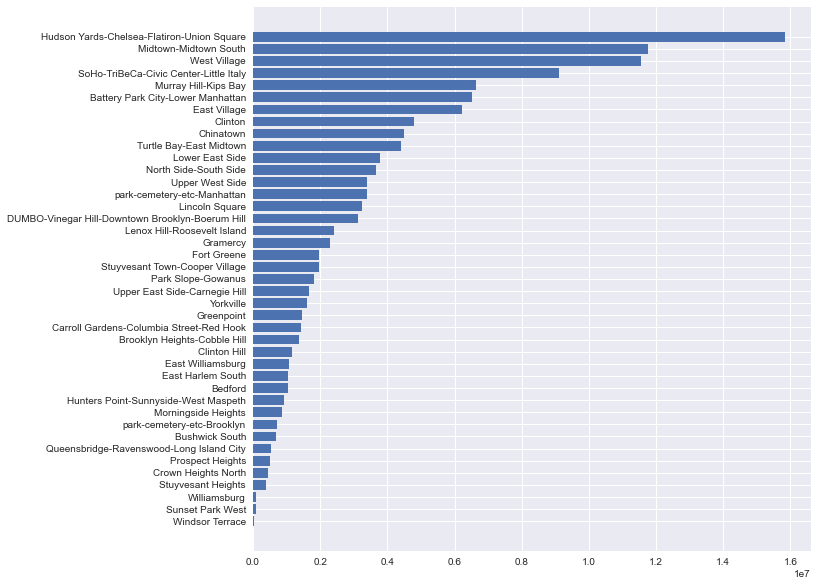

In [50]:
# Plot the total number of rides by neighborhood

fig, ax = plt.subplots(figsize=(10,10))

ax.barh(y=df_neighborhood_sum.index, width=df_neighborhood_sum['total_rides']);

Midtown Manhattan dominates in terms of total ridership since 2013. Parts of Brooklyn (Williamsburg, Sunset Park West, and Windsor Terrace) are towards the bottom. I'm tempted to remove these, but the bottom entry still has a total of 34K rides, so there's plenty of data to build a reasonable time series model.

In [51]:
# Show number of stations per neighborhood

neighborhoood_unique_stations = df_citibike.groupby('neighborhood')[['station_id']].nunique().sort_values('station_id')

for neighborhood, df in df_dict.items():
    
    df_dict[neighborhood]['num_stations'] = neighborhoood_unique_stations.loc[neighborhood, 'station_id']

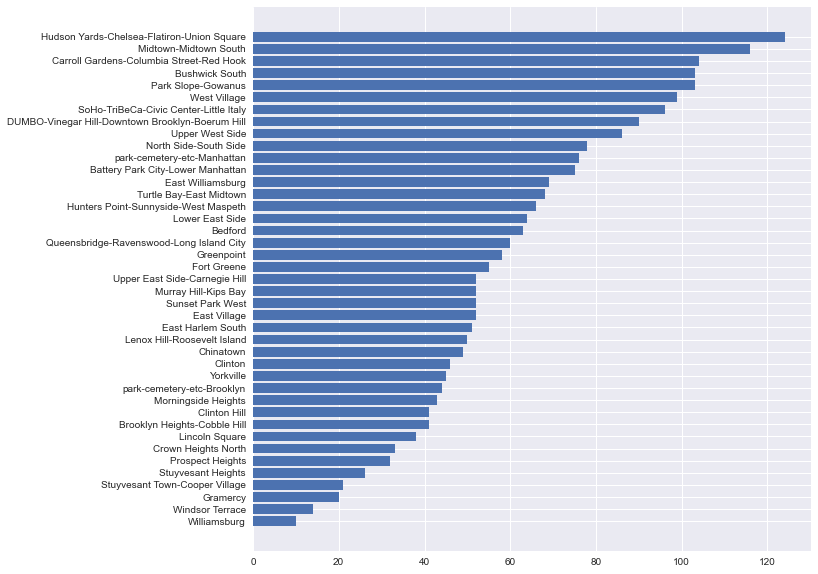

In [52]:
# Plot the number of stations by neighborhood

df_station_count = pd.DataFrame(index=pre_2017_neighborhoods, columns=['total_stations'])

for neighborhood, df in df_dict.items():
    
    df_station_count.loc[neighborhood,:] = df.iloc[0,1]
    
df_station_count.sort_values('total_stations', inplace=True)

# Plot the total number of rides by neighborhood

fig, ax = plt.subplots(figsize=(10,10))

ax.barh(y=df_station_count.index, width=df_station_count['total_stations']);

In [53]:
# Check for stationarity of all the datasets

df_stationary = pd.DataFrame(index=pre_2017_neighborhoods, columns=['stat_pValue', 'is_stationary'])

for i, df in enumerate(df_dict.values()):
    stat, p = dickey_fuller(df['ride_count'], plot_log=True, print_output=False)
    
    df_stationary.iloc[i,:] = [p, stat]
    
df_stationary

,stat_pValue,is_stationary
Clinton,0.009231,True
SoHo-TriBeCa-Civic Center-Little Italy,0.005834,True
Chinatown,0.003691,True
Fort Greene,0.021803,True
Hudson Yards-Chelsea-Flatiron-Union Square,0.006138,True
Bedford,0.445864,False
West Village,0.001411,True
Midtown-Midtown South,0.002761,True
Brooklyn Heights-Cobble Hill,0.053961,False
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,0.039008,True


18 out of the 41 datasets are already technically stationary, but I may still want to log transform to improve the model performance.

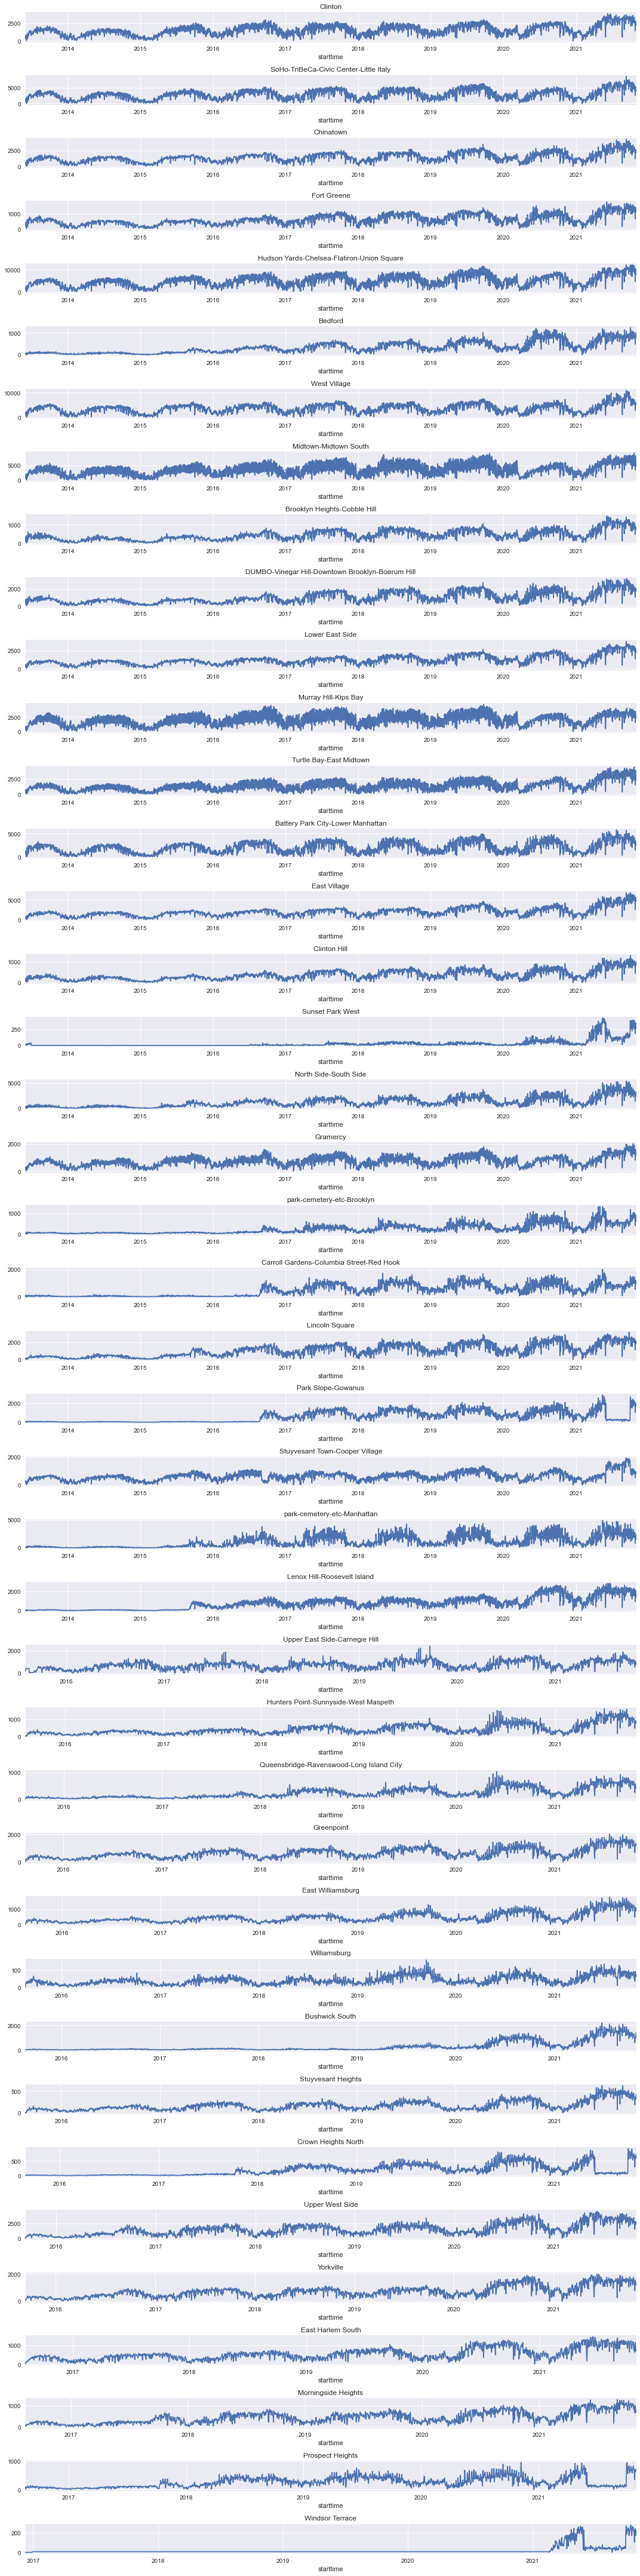

In [54]:
# Plot the time series trend of each neighborhood

fig, ax = plt.subplots(nrows=len(pre_2017_neighborhoods), figsize=(15,60), sharex=False)
i = 0

for neighborhood, df in df_dict.items():
    df['ride_count'].plot(ax=ax[i])
    ax[i].set_title(neighborhood)
    i += 1

    
plt.tight_layout();

A few interesting trends pop out of the time series:
- Most of the larger neighborhoods exhibit a similar trend to the overall series
- Windsor terrace has barely any rides up until 2021, should be excluded. It may be they had some test rides prior to 2017 and snuck into the final neighborhood list as a result. Same goes for Crown Heights North.
- There is a massive decline for some neighborhoods, i.e., Prospect Heights, for parts of 2021. Will need to investigate what's going on with these neighborhoods.

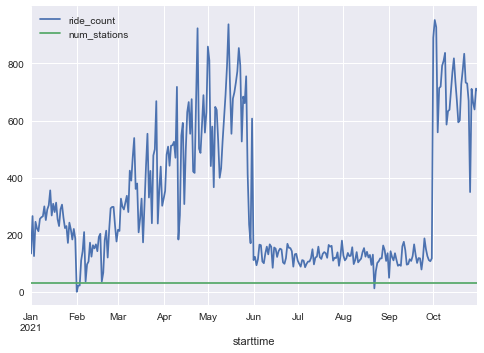

In [55]:
# Investigate neighborhoods that have a drop off in 2021

p_heights = df_dict['Prospect Heights']

p_heights.iloc[1596:,:].plot();

There appears to be a data issue starting in June for a few adjacent neighborhoods in Brooklyn. Since I can't find anything in the news about these stations being offline, my best guess is that there was an upstream data collection issue for these neighborhoods. My first inclination is that since these months won't be part of the training set, it might be ok to ignore them.

## Export final clean data to save

In [60]:
# Clean up final neighborhood set

to_remove = ['Windsor Terrace', 'Crown Heights North']

neighborhood_list_final = [n for n in pre_2017_neighborhoods if n not in to_remove]

pd.DataFrame(neighborhood_list_final).to_csv('./clean_data/neighborhood_list.csv')

In [56]:
# Export final CSV of full dataset

df_citibike.to_csv('./clean_data/final_clean_ridership.csv')

## Addendum: Neighborhood heat map with final neighborhood list

In [65]:
nyc_zip.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904856,"POLYGON ((-73.80379 40.77561, -73.80099 40.775..."
1,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711894,"POLYGON ((-73.86110 40.76366, -73.85993 40.762..."
2,4.0,Queens,081,QN41,Fresh Meadows-Utopia,2.777485e+07,22106.431272,"POLYGON ((-73.77758 40.73019, -73.77849 40.729..."
3,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700375,"POLYGON ((-73.97301 40.76428, -73.97141 40.763..."
4,2.0,Bronx,005,BX09,Soundview-Castle Hill-Clason Point-Harding Park,5.198380e+07,67340.977626,"MULTIPOLYGON (((-73.88064 40.81852, -73.88098 ..."


In [67]:
# Filter for final neighborhood list

nyc_zip_f = nyc_zip[nyc_zip['ntaname'].isin(neighborhood_list_final)]

In [68]:
# Merge in total rides to the shp file

nyc_zip_f = nyc_zip_f.merge(df_neighborhood_sum, left_on='ntaname', right_index=True, how='left')

In [69]:
# Inspect results

nyc_zip_f.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,total_rides
3,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700375,"POLYGON ((-73.97301 40.76428, -73.97141 40.763...",11745886
6,3.0,Brooklyn,047,BK69,Clinton Hill,2.052820e+07,23971.466236,"POLYGON ((-73.95337 40.68064, -73.95328 40.680...",1149521
18,1.0,Manhattan,061,MN12,Upper West Side,3.437994e+07,29160.206256,"POLYGON ((-73.96003 40.79804, -73.96052 40.797...",3402446
30,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520886,"POLYGON ((-73.96939 40.69608, -73.96938 40.695...",1976487
32,1.0,Manhattan,061,MN21,Gramercy,7.526916e+06,12096.891148,"POLYGON ((-73.98239 40.73141, -73.98256 40.731...",2304851


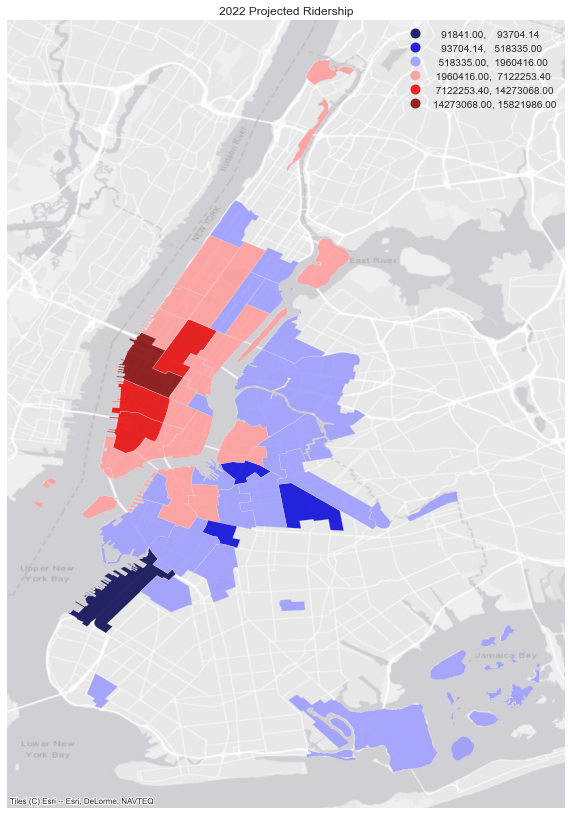

In [86]:
# Show total rides by neighborhood

fig, ax = plt.subplots(figsize=(10,15))

nyc_zip_f.plot(ax=ax, column = 'total_rides', scheme = 'Percentiles', k=10, vmin = 0, cmap = 'seismic',
               edgecolor= 'gainsboro', alpha=.85, legend = True)
# cx.add_basemap(ax, crs=nyc_zip.crs, source=cx.providers.Stamen.TonerBackground)
cx.add_basemap(ax, crs=nyc_zip.crs, source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title("2022 Projected Ridership")
ax.axis('off');

## Next Notebook: Citibike Modeling

https://github.com/marvelje/citibike_ridership_project/blob/main/citibike_modeling.ipynb